In [1]:
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

### Brownian motion
Brownian motion $\{X_t\}_{t\geq 0}$ is a continuous time stochastic process, that satisfies the following properties:
- $X_{0} = 0$.
- The increments are stationary and independent
- It has continuous paths, but nowhere differentiable.
- $X_t - X_s \sim \mathcal{N}(0,t-s)$ for $t\geq s \geq 0$.

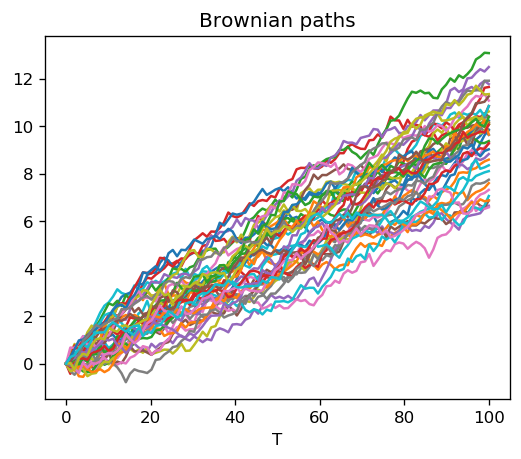

In [2]:
# Browninan motion paths
paths=40             # number of paths
steps=100            # number of time steps
mu = 0.1
sig = 0.2
T = 100
Ts, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        
increments = stats.norm.rvs(loc=mu*dt, scale=sig*np.sqrt(dt), size=(paths,steps-1))
X = np.concatenate((X0,increments), axis=1).cumsum(1)

fig,axes = plt.subplots(figsize=(5,4),dpi=120)
plt.plot(Ts, X.T)
plt.title("Brownian paths")
plt.xlabel("T")
plt.show()

### Geometric Browninan motion
- SDE: $$ dS_t = \mu S_t dt + \sigma S_t dW_t $$
- Solution: $$ S_t = S_0 e^{(\mu-\frac{1}{2}\sigma^2)t + \sigma W_t} $$

$$ \mu : drift $$ 
$$ \sigma: volatility $$

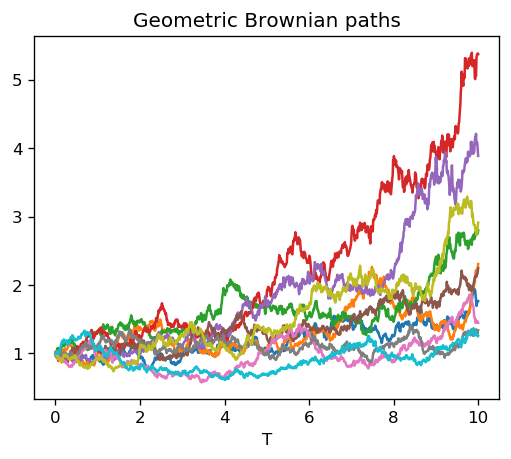

In [3]:
paths=10             # number of paths
steps=1000           # number of time steps
T = 10                
Ts, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths,1))        # each path starts at zero
W = stats.norm.rvs( (mu - 0.5 * sig**2)*dt, np.sqrt(dt)*sig, (paths,steps-1))
X = np.concatenate((X0,W), axis=1).cumsum(1)

fig,axes = plt.subplots(figsize=(5,4),dpi=120)
S_T = np.exp(X)
plt.plot(Ts, S_T.T ); plt.title("Geometric Brownian paths"); plt.xlabel("T")
plt.show()

# European Options Pricing using Black Scholes Model
- Using closed Black Scholes Formula

In [4]:
# S0 : initial asset price
# K : strike price
# r : risk-free interest rate
# q: dividend yield
# sigma : volatility
# T : maturity time

def bs_europ(S0,K,r,q,sigma,T): # return price of call and put options
    d1 = (np.log(S0/K) + (r -q + 0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - (sigma*np.sqrt(T))
    phi_d1 = stats.norm.cdf(d1) # standard normal : loc=0, scale=1
    phi_d2 = stats.norm.cdf(d2)
    phi_d1_ = 1-phi_d1 # Phi(-d1)
    phi_d2_ = 1-phi_d2
    C = S0*np.exp(-q*T)*phi_d1 - K*np.exp(-r*T)*phi_d2
    P = K*np.exp(-r*T)*phi_d2_ - S0*np.exp(-q*T)*phi_d1_
    return C,P

S0=100
K=100
r=0.1
q=0.01
sigma=0.25
T=1
C,P = bs_europ(S0,K,r,q,sigma,T)
print("using Black Scholes Model: C =",C)
print("using Black Scholes Model: P =",P)

using Black Scholes Model: C = 14.286024890597503
using Black Scholes Model: P = 5.764783319276642


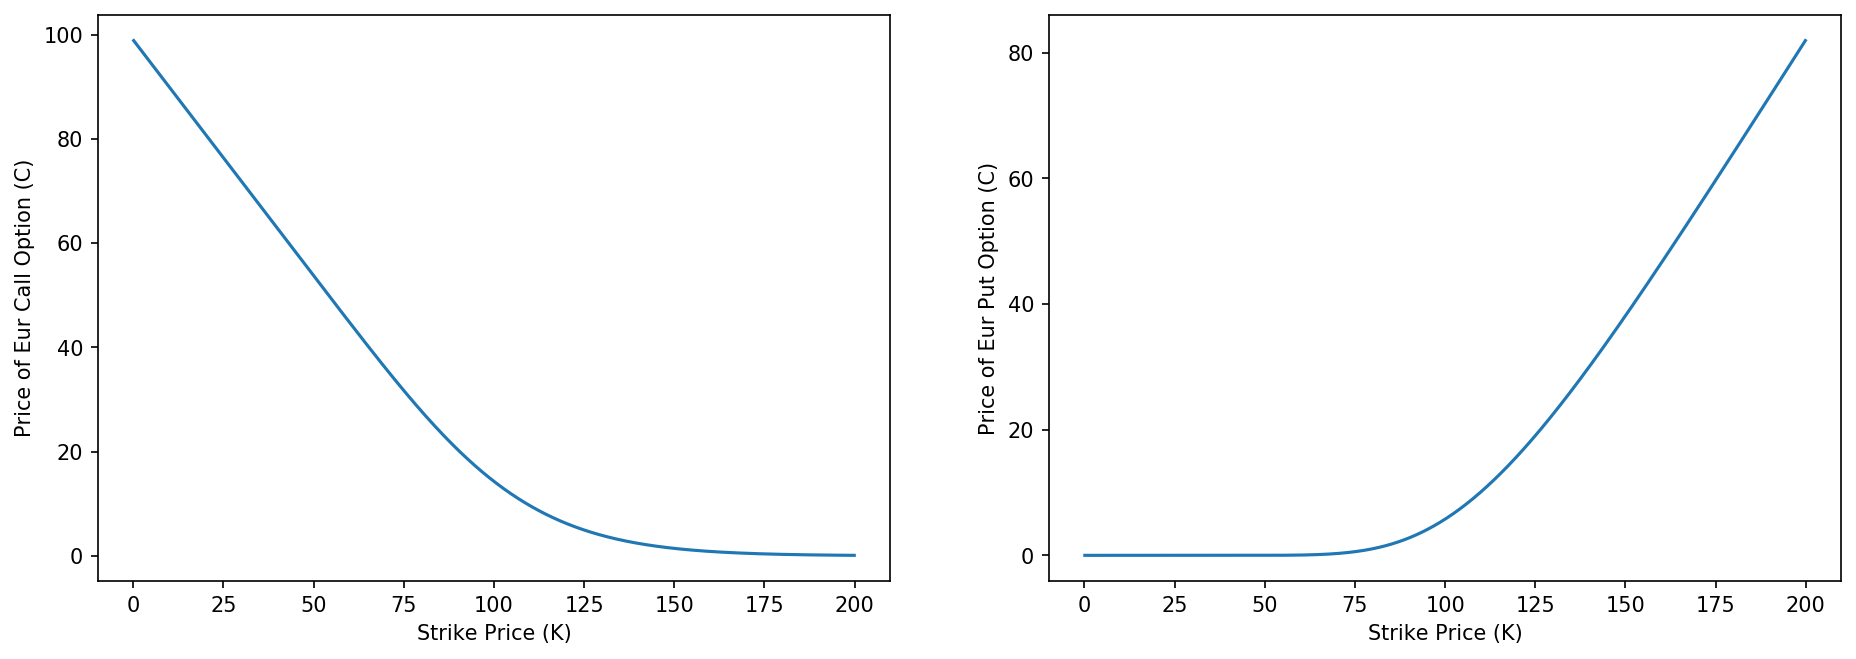

In [6]:
Cs,Ps=[],[]
Ks=np.arange(0.1,200,0.1)
for k in Ks:
    c,p = bs_europ(S0,k,r,q,sigma,T)
    Cs.append(c)
    Ps.append(p)
fig,axes = plt.subplots(figsize=(15,5),ncols=2,dpi=150)
axes[0].plot(Ks,Cs)
axes[1].plot(Ks,Ps)
axes[0].set_ylabel("Price of Eur Call Option (C)")
axes[1].set_ylabel("Price of Eur Put Option (C)")
axes[0].set_xlabel("Strike Price (K)")
axes[1].set_xlabel("Strike Price (K)")
plt.show()

## Using Monte Carlo Simulations

In [7]:
# q: dividend rate
# m: number of simulated paths

def monte_carlo_europ(S,K,r,q,sigma,T,m,opt):
    mu=r-q
    sims = np.random.standard_normal(size=m)
    S_t = S*np.exp( (mu-0.5*(sigma**2))*T + sigma*np.sqrt(T)*sims)
    paths = S_t
    if opt=="Call":
        paths = paths - K
        paths[paths<0]=0
    elif opt=="Put":    
        paths = K-paths
        paths[paths<0]=0
    else:
        raise ValueError("Specify opt = 'Put' or 'Call'")
    V = np.mean(paths)*np.exp(-r*T)
#     sd = np.sqrt(np.sum((paths*np.exp(-r*T) - V)**2)/(m-1))
    sd=np.std(paths*np.exp(-r*T) - V)
    return V

S=100
K=100
r=0.1
q=0.01
sigma=0.25
T=1
print("using Monte Carlo Sims: P =",monte_carlo_europ(S,K,r,q,sigma,T,60000,opt="Call"))
print("using Monte Carlo Sims: C =",monte_carlo_europ(S,K,r,q,sigma,T,60000,opt="Put"))

using Monte Carlo Sims: P = 14.467461782383335
using Monte Carlo Sims: C = 5.735430809199407


## Antithetic variance reduction

In [8]:
# q: dividend rate
# m: number of simulated paths

def monte_carlo_europ_AV(S,K,r,q,sigma,T,m,opt):
    mu = r-q
    sims = np.random.standard_normal(size=m)
    St = S*np.exp((mu-0.5*(sigma**2))*T + sigma*sims)
    St_ = S*np.exp((mu-0.5*(sigma**2))*T - sigma*sims)
    paths = np.array([St,St_])
    if opt=="Call":
        paths = paths - K
        paths[paths<0]=0
    elif opt=="Put":    
        paths = K-paths
        paths[paths<0]=0
    else:
        raise ValueError("Specify opt = 'Put' or 'Call'")
    V = np.mean(paths)*np.exp(-r*T)
    Vt = np.mean(paths,axis=0)
    sd = np.sqrt(np.sum((Vt*np.exp(-r*T) - V)**2)/(m-1))
    return V,sd


S=100
K=100
r=0.1
q=0
sigma=0.25
T=1
print(monte_carlo_europ_AV(S,K,r,q,sigma,T,1000,"Call")[0] )

15.058492547338659


## Using Binomial Model

In [10]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)
    
def binomial_pricing(S0,K,r,sigma,T,N,opt):
    dT = T/N
    u = np.exp(sigma*np.sqrt(dT))
    d = 1/u
    a = np.exp(r*dT) #risk free compounded return
    p_u = (a-d)/(u-d) #risk neutral up probab
    p_d = 1-p_u #risk neutral down probab   
    
    S_t = np.array([S0*(u**j)*(d**(N-j)) for j in range(N+1)])
    
    paths = np.zeros(N+1)
    if opt=="Call":
        paths[:] = np.maximum(S_t-K, 0.0)
    elif opt=="Put":
        paths[:] = np.maximum(K-S_t, 0.0)
    else:
        raise ValueError("Specify opt = 'Put' or 'Call'")

    V=0
    for i in range(N+1):
        V+= paths[i]*nCr(N,i)*(p_u**i)*(p_d**(N-i))
        # alternatively use math.comb for python>=3.8

    return V*np.exp(-r*T)
    
S=100
K=100  
N=150
sigma=0.25
r=0.1
T=1
print("using binomial model: C =",binomial_pricing(S0,K,r,sigma,T,N,"Call"))
print("using binomial model: P =",binomial_pricing(S0,K,r,sigma,T,N,"Put"))

using binomial model: C = 14.958929595345301
using binomial model: P = 5.442671398939843


# American Option Pricing
- Longstaff Schwartz Model

In [26]:
# S0 : initial asset price
# K : strike price
# r : risk-free interest rate
# q: dividend yield
# sigma : volatility
# T : maturity time
# M: time granularity
# sims: no of simulations
def AmericanOptionsLSMC(S0,K,T,M,r,sigma,sims,opt):
    time_unit = T/M
    discount = np.exp(-r*time_unit)
    
    S_t = np.zeros((M + 1, sims), dtype=np.float64)
    S_t[0,:] = S0
    for t in range(1, M + 1):
        paths = np.random.standard_normal( sims// 2)
        paths = np.concatenate((paths, -paths))
        S_t[t, :] = (S_t[t - 1,:] * np.exp((r - sigma**2 / 2)*time_unit + sigma*paths*np.sqrt(time_unit)))
    
    if opt=="Put":
        payoff = np.maximum(K - S_t, np.zeros((M+1, sims)))
    elif opt=="Call":
        payoff = np.maximum(S_t - K, np.zeros((M+1, sims)))
    else:
        raise ValueError("Specify opt = 'Put' or 'Call'")
        
    V = np.zeros_like(payoff)
    V[-1,:] = payoff[-1, :]
    for t in range(M-1,0,-1):
        model = np.polynomial.polynomial.polyfit(S_t[t, :], V[t + 1, :]*discount, 5)
        cont_val = np.polyval(model[::-1], S_t[t, :])
        V[t,:] = np.where(payoff[t, :] > cont_val,payoff[t, :], V[t+1,:]*discount)

    V = V[1,:]*discount
    V = np.sum(V)/sims
    return V

S0=100;K=100;T=1;M=50;r=0.1;sigma=0.25;sims=1000
print("American Call option:",AmericanOptionsLSMC(S0,K,T,M,r,sigma,sims,"Call"))
print("American Put option:",AmericanOptionsLSMC(S0,K,T,M,r,sigma,sims,"Put"))

American Call option: 14.69860053852038
American Put option: 6.679558710340395


In [28]:
def delta(S0,K,T,M,r,sigma,sims,opt):
    diff = S0*0.01
    V1=AmericanOptionsLSMC(S0+diff,K,T,M,r,sigma,sims,opt)
    V2=AmericanOptionsLSMC(S0-diff,K,T,M,r,sigma,sims,opt)
    return (V1-V2)/(2*diff)

def gamma(S0,K,T,M,r,sigma,sims,opt):
    diff = S0*0.01
    D1 = delta(S0+diff,K,T,M,r,sigma,sims,opt)
    D2 = delta(S0-diff,K,T,M,r,sigma,sims,opt)
    return (D1-D2)/(2*diff)
    
def vega(S0,K,T,M,r,sigma,sims,opt):
    diff = sigma*0.01
    V1=AmericanOptionsLSMC(S0+diff,K,T,M,r,sigma+diff,sims,opt)
    V2=AmericanOptionsLSMC(S0-diff,K,T,M,r,sigma-diff,sims,opt)
    return (V1-V2)/(2*diff)
    
def rho(S0,K,T,M,r,sigma,sims,opt):
    diff = r*0.01
    V1 = AmericanOptionsLSMC(S0,K,T,M,r+diff,sigma,sims,opt)
    if r-diff<0: 
        V2 = AmericanOptionsLSMC(S0,K,T,M,r,sigma,sims,opt)
        return (V1-V2)/(diff)
    else:
        V2 = AmericanOptionsLSMC(S0,K,T,M,r-diff,sigma,sims,opt)
        return (V1-V2)/(2*diff)
    
def theta(S0,K,T,M,r,sigma,sims,opt):
    diff = 1/252
    V1=AmericanOptionsLSMC(S0,K,T+diff,M,r,sigma,sims,opt)
    V2=AmericanOptionsLSMC(S0,K,T-diff,M,r,sigma,sims,opt)
    return (V1-V2)/(2*diff)
    

In [29]:
print("Delta:",delta(S0,K,T,M,r,sigma,sims,"Put"))
print("gamma:",gamma(S0,K,T,M,r,sigma,sims,"Put"))
print("vega:",vega(S0,K,T,M,r,sigma,sims,"Put"))
print("rho:",rho(S0,K,T,M,r,sigma,sims,"Put"))
print("theta:",theta(S0,K,T,M,r,sigma,sims,"Put"))

Delta: -0.6052677824890851
gamma: -0.053032009449686696
vega: 67.08486264992573
rho: -151.5966927427814
theta: -6.72114772645611
